# import 套件

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# 先查看資料格式

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-10-2020.csv'
march10 = pd.read_csv(url)
march10.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,Mainland China,2020-03-10T15:13:05,67760,3024,47743,30.9756,112.2707
1,NaN,Italy,2020-03-10T17:53:02,10149,631,724,43.0000,12.0000
2,NaN,Iran (Islamic Republic of),2020-03-10T19:13:20,8042,291,2731,32.0000,53.0000
3,NaN,Republic of Korea,2020-03-10T19:13:20,7513,54,247,36.0000,128.0000
4,NaN,France,2020-03-10T18:53:02,1784,33,12,47.0000,2.0000


# 以3/10為例，畫出散佈圖及熱點圖

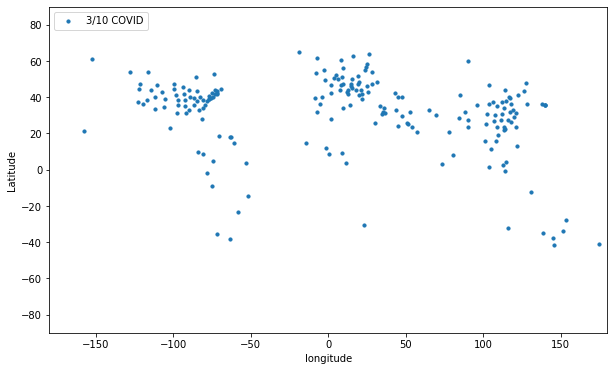

In [3]:
# plot 3/10's COVID infection instances on a earth map
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.scatter(march10.Longitude, march10.Latitude, alpha = 1, s = 10, label = "3/10 COVID")
ax.set_xlim((-180, 180))
ax.set_ylim((-90, 90))

plt.xlabel("longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper left')
plt.show()

In [4]:
import folium
from folium.plugins import HeatMap
mapa = folium.Map(location=(20, 20), zoom_start=1, tiles="Stamen Toner", height="50%", width="50%")
loc_li = list(zip(march10.Latitude, march10.Longitude))
HeatMap(loc_li, radius=15).add_to(mapa) # <-----------------------change radius
mapa

# 為2月以前的資料加上座標，以3/10的座標join

In [5]:
date = datetime.date(2020, 1, 22)
oneDay = datetime.timedelta(days=1)
dueDate = datetime.date(2020, 3, 11)

In [6]:
dailys = []
while date!= dueDate:
    _ = date.strftime('%m-%d-%Y')
    dailys.append(pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv'.format(_), index_col=[0,1]))
    date+=oneDay

In [7]:
location = dailys[-1][['Latitude', 'Longitude']]

In [8]:
allDailyReports = []
for i in range(39):
    allDailyReports.append(dailys[i].join(location, how='inner',lsuffix='_'))

In [9]:
allDailyReports = allDailyReports+dailys[39:]

## 從1/22開始將傳染區域畫出

In [10]:
from folium.plugins import HeatMapWithTime

In [13]:
heatMapList = []
for each in allDailyReports:
    loc = [list(a) for a in zip(each.Latitude, each.Longitude)]
    heatMapList.append(loc)

In [14]:
fmap = folium.Map(location=(20, 20), zoom_start=1, tiles="Stamen Toner", height="50%", width="50%")
fmap.add_child(HeatMapWithTime(heatMapList, radius=15)) # 顯示連續熱度圖

# 各國確診成長趨勢比較

In [15]:
trend = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [16]:
trend.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,360,420,461,502,511,581,639,639,701,773
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,117,130,138,150,150,160,178,178,200,212
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,83,93,99,117,129,149,149,197,238


In [17]:
trend = trend.drop(columns=['Lat', 'Long', 'Province/State'])
aggr_func = {i:'sum' for i in trend.columns[1:]}

In [18]:
trend = trend.groupby(['Country/Region'],as_index=False).agg(aggr_func).sort_values(by=['3/14/20'],ascending=False)
confirmed = trend[trend['3/14/20']!=0].set_index('Country/Region')

In [19]:
top5 = confirmed[:5].T

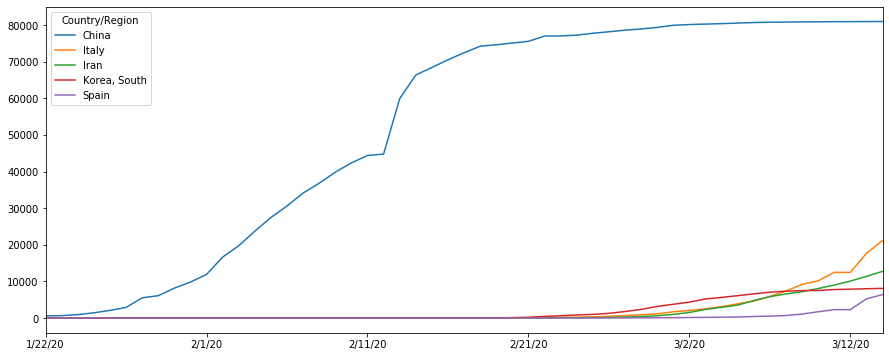

In [20]:
top5.plot(figsize=(15,6))

# 截至目前各國感染比例

In [21]:
p = confirmed[['3/14/20']]/confirmed['3/14/20'].sum()

In [22]:
p.head()

,3/14/20
Country/Region,
China,0.518744
Italy,0.135533
Iran,0.081543
"Korea, South",0.051799
Spain,0.040941


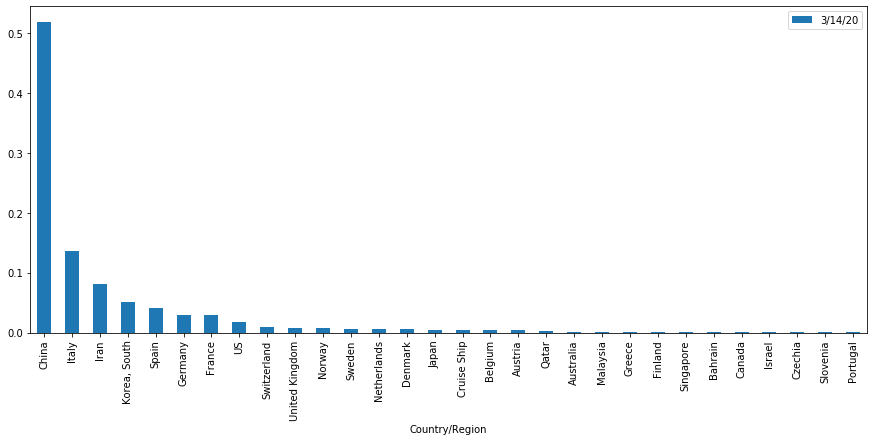

In [23]:
p[:30].plot.bar(figsize=(15,6))

# 各國當前痊癒率及死亡率

In [39]:
def df_Regular(df, threshold):
    df = df.groupby(['Country/Region'],as_index=False).agg(aggr_func).sort_values(by=['3/14/20'],ascending=False)
    df = df[df['3/14/20']>=threshold].set_index('Country/Region')
    df = df[['3/14/20']]
    return df

In [40]:
rec = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
conf = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [41]:
rec = df_Regular(rec, 1)
death = df_Regular(death, 0)
conf = df_Regular(conf, 5)

In [42]:
recoverRate = (rec/conf).sort_values(by='3/14/20', ascending=False)

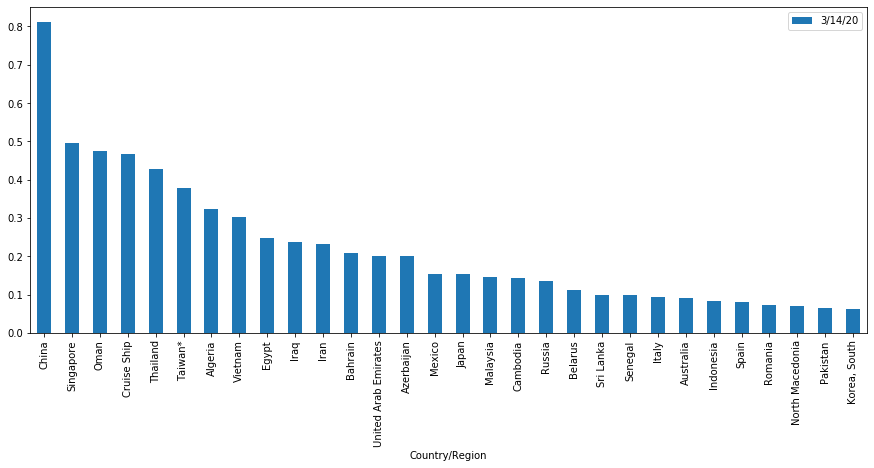

In [43]:
recoverRate[:30].plot.bar(figsize=(15, 6))

In [44]:
deathRate = (death/conf).sort_values(by='3/14/20', ascending=False)

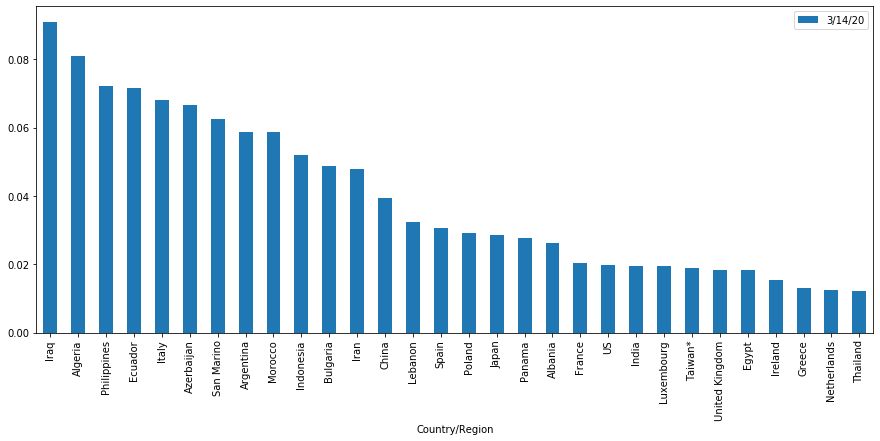

In [45]:
deathRate[:30].plot.bar(figsize=(15, 6))